In [36]:
import os
import cv2
import numpy as np
from collections import defaultdict
import time

def obtenir_statistiques_images(repertoire_images):
    start_time = time.time()
    
    image_count = 0
    stats_resolution = []
    compte_categories = defaultdict(int)
    moyennes_pixels = []
    std_pixels = []
    fichiers_manquants = []

    for racine, _, fichiers in os.walk(repertoire_images):
        for fichier in fichiers:
            if fichier.endswith(('.png', '.jpg', '.jpeg')):
                image_count += 1
                chemin_fichier = os.path.join(racine, fichier)
                try:
                    image = cv2.imread(chemin_fichier)
                    if image is None:
                        fichiers_manquants.append(chemin_fichier)
                        continue
                    h, w, _ = image.shape
                    stats_resolution.append((h, w))
                    moyennes_pixels.append(np.mean(image))
                    std_pixels.append(np.std(image))
                    categorie = os.path.basename(racine)
                    compte_categories[categorie] += 1
                except Exception as e:
                    fichiers_manquants.append(chemin_fichier)
                    print(f"Erreur de lecture {chemin_fichier}: {e}")

    total_resolutions = np.array(stats_resolution)
    avg_resolution = np.mean(total_resolutions, axis=0)
    min_resolution = np.min(total_resolutions, axis=0)
    max_resolution = np.max(total_resolutions, axis=0)

    overall_mean = np.mean(moyennes_pixels)
    overall_std = np.std(std_pixels)

    stats = {
        'compte_images': image_count,
        'resolution_moyenne': avg_resolution,
        'resolution_minimale': min_resolution,
        'resolution_maximale': max_resolution,
        'compte_categories': dict(compte_categories),
        'moyenne_globale': overall_mean,
        'std_globale': overall_std,
        'fichiers_manquants': fichiers_manquants
    }

    end_time = time.time()
    stats['temps_de_calcul'] = end_time - start_time

    return stats

def afficher_statistiques(repertoire_images):
    stats = obtenir_statistiques_images(repertoire_images)
    print("Résultats des statistiques :")
    print(f"Nombre total d'images: {stats['compte_images']}")
    print(f"Résolution moyenne: {stats['resolution_moyenne']}")
    print(f"Résolution minimale: {stats['resolution_minimale']}")
    print(f"Résolution maximale: {stats['resolution_maximale']}")
    print("Distribution des catégories :")
    for categorie, compte in stats['compte_categories'].items():
        print(f"  {categorie}: {compte} images")
    print(f"Moyenne des pixels: {stats['moyenne_globale']}")
    print(f"Écart type des pixels: {stats['std_globale']}")
    if stats['fichiers_manquants']:
        print("Fichiers d'images manquants ou endommagés :")
        for fichier in stats['fichiers_manquants']:
            print(f"  {fichier}")
    print(f"Temps de calcul: {stats['temps_de_calcul']} secondes")

repertoire_images = './data/raw'  # Remplacez par le chemin de votre propre ensemble d'images
afficher_statistiques(repertoire_images)



Résultats des statistiques :
Nombre total d'images: 1756
Résolution moyenne: [109.14806378 145.60022779]
Résolution minimale: [99 84]
Résolution maximale: [150 150]
Distribution des catégories :
  samoyede: 476 images
  berger_allemand: 640 images
  carlin: 640 images
Moyenne des pixels: 122.14087625519366
Écart type des pixels: 12.08149025925452
Temps de calcul: 0.6501688957214355 secondes


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

dataset_path = './data/raw'  # Modifiez avec le chemin de votre dataset

# Initialiser une liste pour stocker les données
data = []

# Parcourir le répertoire du dataset
for breed in os.listdir(dataset_path):
    breed_path = os.path.join(dataset_path, breed)
    if os.path.isdir(breed_path):
        for img_name in os.listdir(breed_path):
            img_path = os.path.join(breed_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img_array = np.array(img)
                    width, height = img.size
                    data.append((img_array, breed, width, height))
            except Exception as e:
                print(f"Erreur lors du chargement de l'image {img_path}: {e}")

# Convertir en DataFrame pour faciliter la manipulation
df = pd.DataFrame(data, columns=['image', 'breed', 'width', 'height'])


/var/folders/l2/wcl7qkbj6tb3lmdhswqlh3jr0000gn/T/ipykernel_64012/3686985958.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


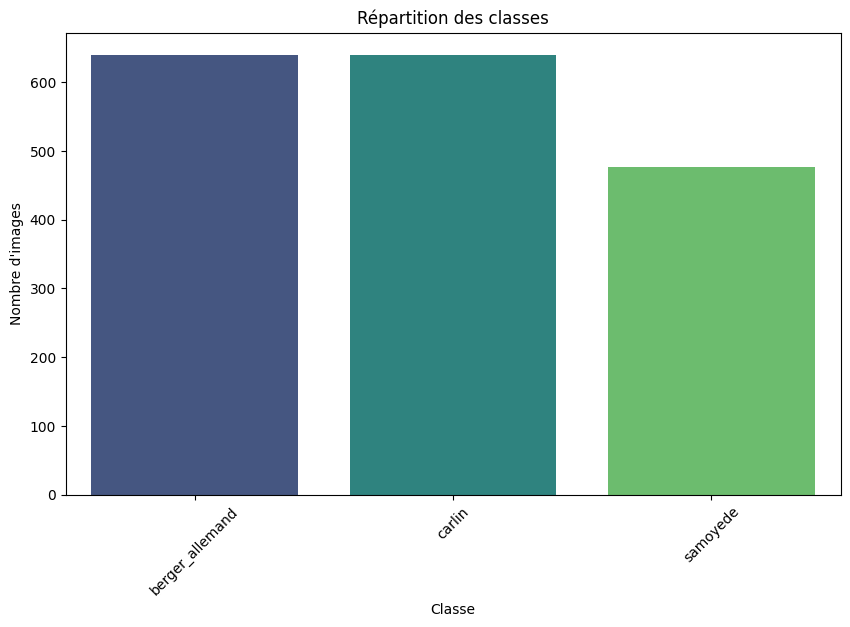

In [24]:
# Définir une fonction pour tracer la répartition des classes
def plot_class_distribution(labels):
    # Calculer le nombre d'images pour chaque classe
    class_counts = pd.Series(labels).value_counts()

    # Tracer un diagramme à barres
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Répartition des classes')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'images')
    plt.xticks(rotation=45)
    plt.show()
    
# Appeler la fonction pour visualiser la répartition des classes
plot_class_distribution(df['breed'])


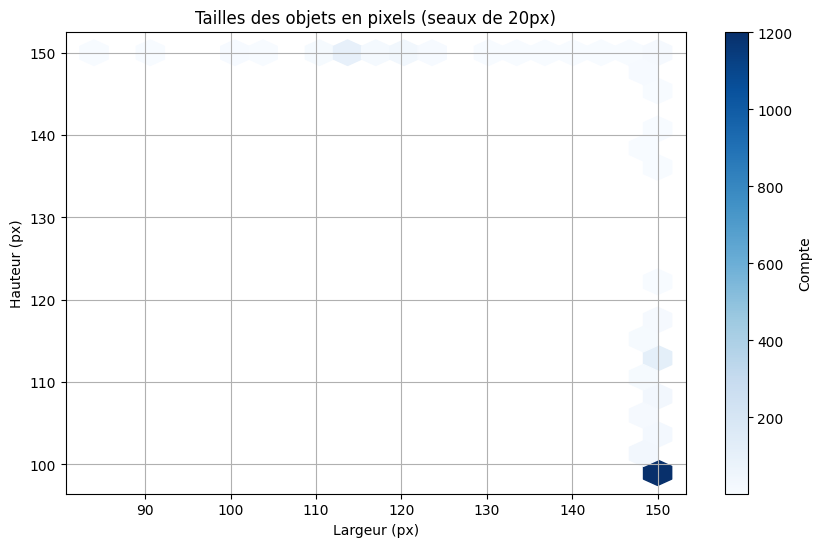

In [25]:
# Tracer le diagramme de dispersion de la largeur et de la hauteur des images (chaque 20 pixels un seau)
plt.figure(figsize=(10, 6))
plt.hexbin(df['width'], df['height'], gridsize=20, cmap='Blues', mincnt=1)
plt.colorbar(label='Compte')
plt.title('Tailles des objets en pixels (seaux de 20px)')
plt.xlabel('Largeur (px)')
plt.ylabel('Hauteur (px)')
plt.grid(True)
plt.show()


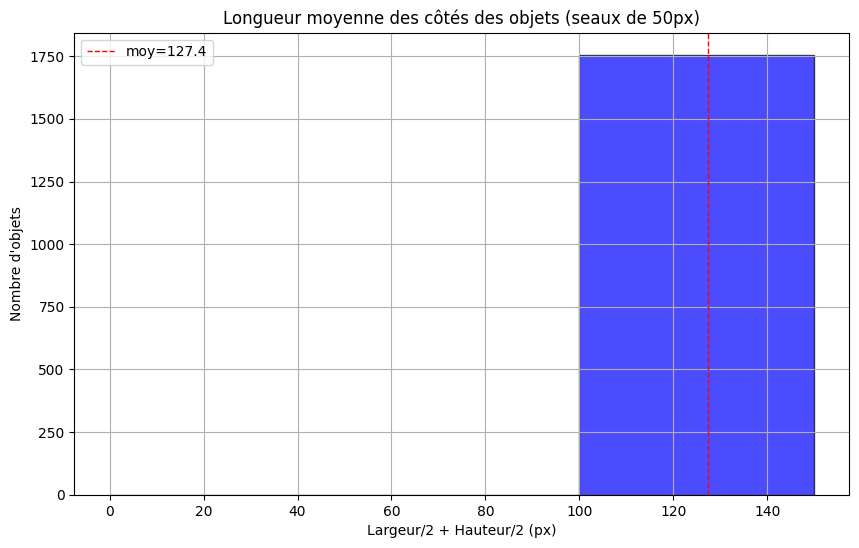

In [26]:
# Calculer la longueur moyenne des côtés
df['average_side_length'] = (df['width'] + df['height']) / 2

# Tracer l'histogramme de la longueur moyenne des côtés (chaque 50 pixels un seau)
plt.figure(figsize=(10, 6))
plt.hist(df['average_side_length'], bins=np.arange(0, df['average_side_length'].max() + 50, 50), alpha=0.7, color='b', edgecolor='black')
plt.axvline(df['average_side_length'].mean(), color='r', linestyle='dashed', linewidth=1, label=f'moy={df["average_side_length"].mean():.1f}')
plt.legend()
plt.title('Longueur moyenne des côtés des objets (seaux de 50px)')
plt.xlabel('Largeur/2 + Hauteur/2 (px)')
plt.ylabel('Nombre d\'objets')
plt.grid(True)
plt.show()


/Users/xinleichen/miniconda3/envs/TAA/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


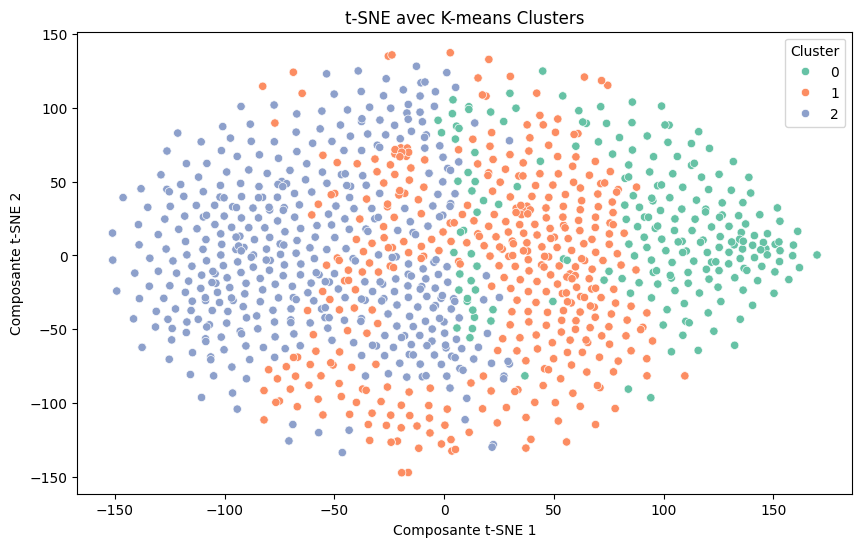

In [27]:
# Redimensionner les images
target_size = (150, 150)
resized_images = []

for img_array in df['image']:
    img = Image.fromarray(img_array)
    img = img.resize(target_size)
    resized_images.append(np.array(img))

# Préparer les données pour t-SNE et K-means
flattened_images = [img.flatten() for img in resized_images]  # Aplatir les images
flattened_images = np.array(flattened_images)

# Exécuter t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(flattened_images)

# Stocker les résultats t-SNE dans le DataFrame
df_tsne = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])

# Exécuter K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_result = kmeans.fit_predict(flattened_images)

# Stocker les résultats de clustering dans le DataFrame
df_tsne['cluster'] = kmeans_result

# Visualiser les résultats de t-SNE avec les clusters K-means
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', data=df_tsne, palette='Set2')
plt.title('t-SNE avec K-means Clusters')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.legend(title='Cluster')
plt.show()